In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, AveragePooling2D, BatchNormalization, Permute, ReLU, Softmax
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [2]:
def get_files(directory):
    # Path to the directory you want to explore
    # directory = 'empty'  # Current directory, change this to your target path

    # Get all directories and files
    all_items = []
    for dirpath, _, filenames in os.walk(directory):
        # Add directories
        # for dirname in dirnames:
        #     path = os.path.join(dirpath, dirname)
        #     all_items.append(path)
        
        # Add files
        for filename in filenames:
            path = os.path.join(dirpath, filename)
            all_items.append(path)
    
    return all_items

In [3]:
raw = []
label = []

mapping = {
    'empty': [1.0, 0.0],
    'water_package': [0.0, 1.0],
}

for csv in get_files('empty') + get_files('water_package'):
    waveform = pd.read_csv(csv)['value'].to_numpy() * 3.3 / 4095
    waveform -= np.median(waveform)
    raw += [waveform]
    label += [mapping[csv.split('\\')[0]]]

raw = np.fft.rfft(raw, n=511, axis=1)
label = np.array(label)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    raw, label, test_size=0.2, random_state=42
)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_dataset = validation_dataset.batch(32)

In [5]:
model = Sequential([
    InputLayer(input_shape=(256,)),
    Dense(300, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.00001)),
    Dense(32, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.00001)),
    Dense(2, activation='softmax'),
])
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=1000, validation_data=validation_dataset, verbose=2)

Epoch 1/1000


c:\Users\zqxwc\OneDrive\桌面\STM32-Oscilloscope-Application-V1\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


6/6 - 2s - 292ms/step - accuracy: 0.4689 - loss: 0.9085 - val_accuracy: 0.6222 - val_loss: 0.8354
Epoch 2/1000
6/6 - 0s - 6ms/step - accuracy: 0.8079 - loss: 0.4790 - val_accuracy: 0.5556 - val_loss: 0.8230
Epoch 3/1000
6/6 - 0s - 8ms/step - accuracy: 0.9661 - loss: 0.2758 - val_accuracy: 0.5556 - val_loss: 0.8393
Epoch 4/1000
6/6 - 0s - 9ms/step - accuracy: 0.9887 - loss: 0.2070 - val_accuracy: 0.5556 - val_loss: 0.8511
Epoch 5/1000
6/6 - 0s - 8ms/step - accuracy: 0.9944 - loss: 0.1525 - val_accuracy: 0.5778 - val_loss: 0.8533
Epoch 6/1000
6/6 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.1226 - val_accuracy: 0.6000 - val_loss: 0.8671
Epoch 7/1000
6/6 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.1054 - val_accuracy: 0.6222 - val_loss: 0.8798
Epoch 8/1000
6/6 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.0924 - val_accuracy: 0.5778 - val_loss: 0.8898
Epoch 9/1000
6/6 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0840 - val_accuracy: 0.5778 - val_loss: 0.9033
Epoch 10/1000
6/6 - 0s - 8ms/

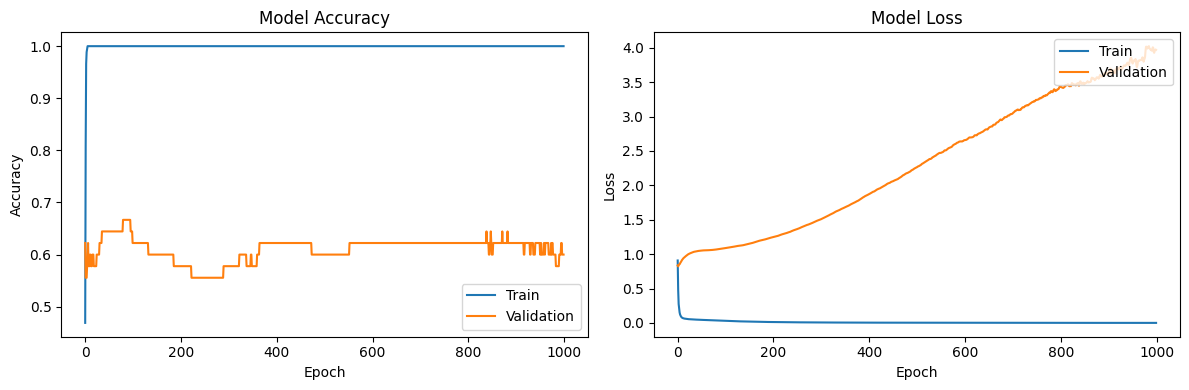

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

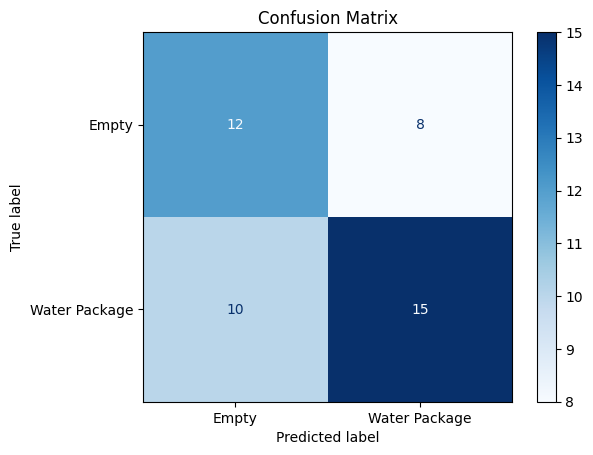

               precision    recall  f1-score   support

        Empty       0.55      0.60      0.57        20
Water Package       0.65      0.60      0.62        25

     accuracy                           0.60        45
    macro avg       0.60      0.60      0.60        45
 weighted avg       0.60      0.60      0.60        45

Overall Accuracy: 0.6000
Water Package Detection Sensitivity: 0.6000
Water Package Detection Specificity: 0.6000


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the model
y_pred_prob = []
y_true = []

# Iterate through validation dataset to get predictions and true labels
for x, y in validation_dataset:
    y_pred_prob.append(model.predict(x, verbose=0))
    y_true.append(y)

# Convert to numpy arrays
y_pred_prob = np.concatenate(y_pred_prob, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_true, axis=1)

# Define class names
class_names = ['Empty', 'Water Package']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# Print classification report with class names
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate and print accuracy
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Overall Accuracy: {accuracy:.4f}")

# Calculate sensitivity (recall) for water package detection
water_package_idx = 1
sensitivity = cm[water_package_idx, water_package_idx] / np.sum(cm[water_package_idx, :])
print(f"Water Package Detection Sensitivity: {sensitivity:.4f}")

# Calculate specificity (true negative rate) for water package detection
specificity = cm[0, 0] / np.sum(cm[0, :])
print(f"Water Package Detection Specificity: {specificity:.4f}")